<div align="center">

  <img src="./docs/genshin.png" style="height: 100px!important;">

  <h1>Genshin Impact</h1>
  <h4>Melihat seberapa <i>retard</i> pemain Indonesia di game ini melalui review mereka....</h4>
</div>
<br><br>

## Tentang Projek

| Judul             | Sentiment Analysis Review Genshin Impact                               |
|-------------------|-------------------------------------|
| Kelas              | Informatika A 21 - A1 - 2 |
| Tema              | Neural Language Processing (NLP) |
| Matkul            | Kecerdasan Buatan                     |
| Angkatan          | Semester 3 - 2021                   |
| Total Dataset          | 12.000                   |


## Anggota
| FOTO       | NIM                     | NAMA               | BAGIAN                              |
|------------|-------------------------|--------------------|-------------------------------------|
| <img src="./docs/herni.jpg"  style="height: 100px!important;"> | 2109106001          | Herni Suhartati   | Visualisasi Data              |
| <img src="./docs/rahman.jpg"  style="height: 100px!important;"> | 2109106016          | M. Rahman   | Validasi & Evaluasi              |
| <img src="./docs/bayu.png"  style="height: 100px!important;"> | 2109106024          | Bayu Setiawan   | Scraping & Modeling              |


In [1]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Data Collecting

Tahapan ini ada pada `scraping.ipynb` yang dimana kita mengambil dataset sejumlah 12.000 review dari google play store menggunakan `google-play-scraper`

### 2. Data Preprocessing

#### a. Data Info

In [29]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable


In [30]:
df = pd.read_csv('./dataset/reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  12000 non-null  object
 1   userName  12000 non-null  object
 2   content   12000 non-null  object
 3   score     12000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 375.1+ KB


#### b. Data Sample
Berikut merupakan struktur dataset yang dipakai:
1. **reviewId**: Merupakan id yang diberikan oleh Google per review yang, tentu data ini bersifat unik
2. **userName**: Nama user yang memberikan review
3. **content**: Text review mereka
4. **score**: Rating yang diberikan, scale 1 hingga 5

In [31]:
df.head()

,reviewId,userName,content,score
0,eeb31930-2431-428a-9f4e-baf93928cf94,Dzaki Abdullah Fawwaaz,"GAME NYA BAGUS BANGET, MULAI DARI STORY, EVENT...",5
1,cf26cb0f-e84c-4c0d-93a6-613f1fe34cec,Ajeng Rasti,Scaramouche.,5
2,d36cfcac-6ac9-40ff-ab44-f59b345e35fa,Yanti Baru,Yah pokoknya bagus deh Grafik bagus . Karakter...,5
3,b42f0cbb-da51-403d-b23a-10b571ff007e,Muh.fauzan Fausan,Grafik nya mantap pol tapi aku masih download ...,5
4,f2a1e9dd-e3d2-4b4b-ae0c-1d167f19a047,Rina Rahmawati,Game bagus,5


#### c. Data Sentiment

Di kita akan menambahkan kolom baru pada DataFrame yaitu `sentiments` untuk membagi kelompok dari review. 0 untuk `score <= 2` dan 1 untuk `score >= 3`

In [32]:
df['sentiments'] = df.score.apply(lambda x: 0 if x in [1, 2] else 1)

### 3. Data Analysis and Visualization

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

#### a. Visualisasi terhadapat sentiment

Visualisasi pertama yang kita lakukan adalah pembagian persentase *sentiment* positif dan negatif yang ada dengan menggunakan **Pie Chart**

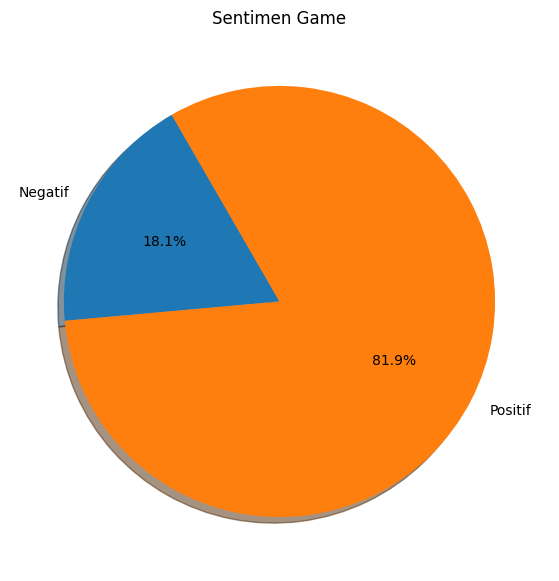

In [34]:
plt.figure(figsize=(15,7))
# sentimen = df.dropna(subset=['sentiments']).sort_values(by=['sentiments'])['sentiments'].unique()
total = df.groupby(['sentiments'])['score'].count()
plt.pie(total, labels=(["Negatif", "Positif"]), autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Sentimen Game')
plt.show()


#### b. Visualisasi Terhadap Rating

Kembali kita menggunakan **Pie Chart** untuk menggambarkan pembagian review berdasarkan rating yang diberikan

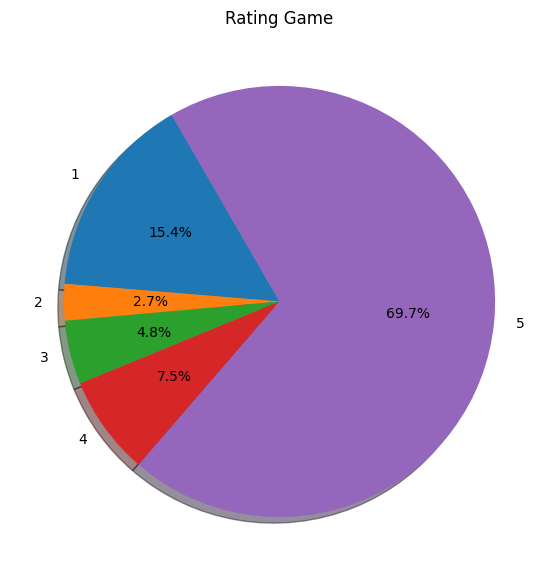

In [35]:
plt.figure(figsize=(15,7))
rating = df.dropna(subset=['score']).sort_values(by=['score'])['score'].unique()
total = df.groupby(['score'])['reviewId'].count()
plt.pie(total, labels=rating, autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Rating Game')
plt.show()


#### c. Visualisasi Kata ter Banyak dengan Word Cloud

**Word Cloud** kami gunakan untuk memvisualisasikan kata yang sering muncul dalam teks review yang diberikan.

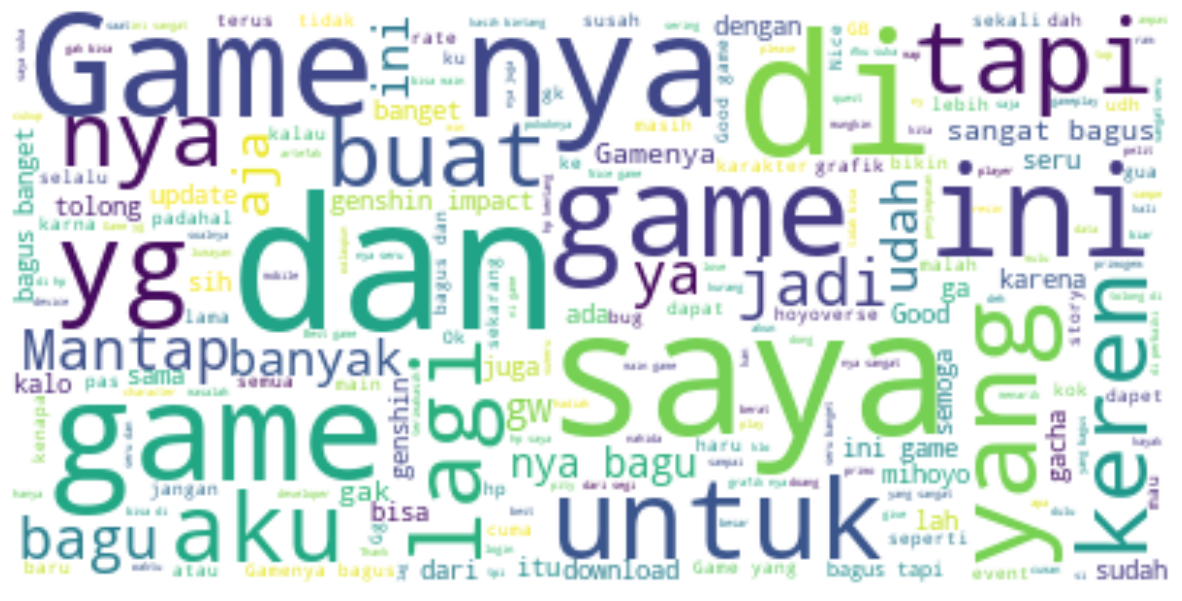

In [36]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


text = " ".join(i for i in df.content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Data Modeling

In [93]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Pada pembagian data berikut, kami menggunakan **60% Data Training** dan **40% Data Validasi**

In [94]:
x_train, x_validation, y_train, y_validation = train_test_split(df['content'], df['sentiments'], test_size=0.4, shuffle=True)


Di sini kita akan kembali melakukan pengecekan ekstra untuk memastikan bahwa data benar-benar teks

In [95]:
# proses memasukan data pada database yaitu field content dan sentiments ke dalam variabel array
import numpy as np
training_sentences = []
training_labels = []
validation_sentences = []
validation_labels = []
for row in x_train:
    training_sentences.append(str(row))
for row in y_train:
    training_labels.append(row)
for row in x_validation:
    validation_sentences.append(str(row))
for row in y_validation:
    validation_labels.append(row)


In [96]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_token = '<OOV>'
padding_type = 'post'

In [97]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index


table=PrettyTable(['Kata', 'Indeks'])
table.title = "Indeks Kata"
table._max_width = {"Kata" : 30, "Indeks" : 10}
for key, value in word_index.items():
    table.add_row([key, value])

print(table)


+-----------------------------------------+
|               Indeks Kata               |
+--------------------------------+--------+
|              Kata              | Indeks |
+--------------------------------+--------+
|             <OOV>              |   1    |
|              game              |   2    |
|             bagus              |   3    |
|              nya               |   4    |
|               di               |   5    |
|              saya              |   6    |
|              ini               |   7    |
|              dan               |   8    |
|              yang              |   9    |
|              bisa              |   10   |
|              tapi              |   11   |
|             sangat             |   12   |
|             untuk              |   13   |
|             banget             |   14   |
|              seru              |   15   |
|              main              |   16   |
|               yg               |   17   |
|             tolong            

In [98]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
validation_sentences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sentences, maxlen=max_length)

In [99]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [100]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 6)                 102       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________


In [102]:
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

In [103]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final))

Epoch 1/20
225/225 [==============================] - 4s 12ms/step - loss: 0.5699 - accuracy: 0.8056 - val_loss: 0.4697 - val_accuracy: 0.8217
Epoch 2/20
225/225 [==============================] - 2s 11ms/step - loss: 0.4667 - accuracy: 0.8174 - val_loss: 0.4590 - val_accuracy: 0.8217
Epoch 3/20
225/225 [==============================] - 2s 11ms/step - loss: 0.4619 - accuracy: 0.8174 - val_loss: 0.4565 - val_accuracy: 0.8217
Epoch 4/20
225/225 [==============================] - 3s 12ms/step - loss: 0.4584 - accuracy: 0.8174 - val_loss: 0.4533 - val_accuracy: 0.8217
Epoch 5/20
225/225 [==============================] - 3s 13ms/step - loss: 0.4533 - accuracy: 0.8174 - val_loss: 0.4481 - val_accuracy: 0.8217
Epoch 6/20
225/225 [==============================] - 3s 15ms/step - loss: 0.4413 - accuracy: 0.8192 - val_loss: 0.4374 - val_accuracy: 0.8231
Epoch 7/20
225/225 [==============================] - 3s 12ms/step - loss: 0.4208 - accuracy: 0.8232 - val_loss: 0.4208 - val_accuracy: 0.8246

In [104]:
model.save("./model/model_finished.h5")

### 4. Evaluasi

#### a. Validasi

In [105]:
print("Evaluate on test data")
results = model.evaluate(validation_padded, validation_labels_final, batch_size=128)
print("validation loss, validation acc:", results)

Evaluate on test data
38/38 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8458
validation loss, validation acc: [0.35973283648490906, 0.8458333611488342]


#### b. Visualisasi Akurasi dan Loss

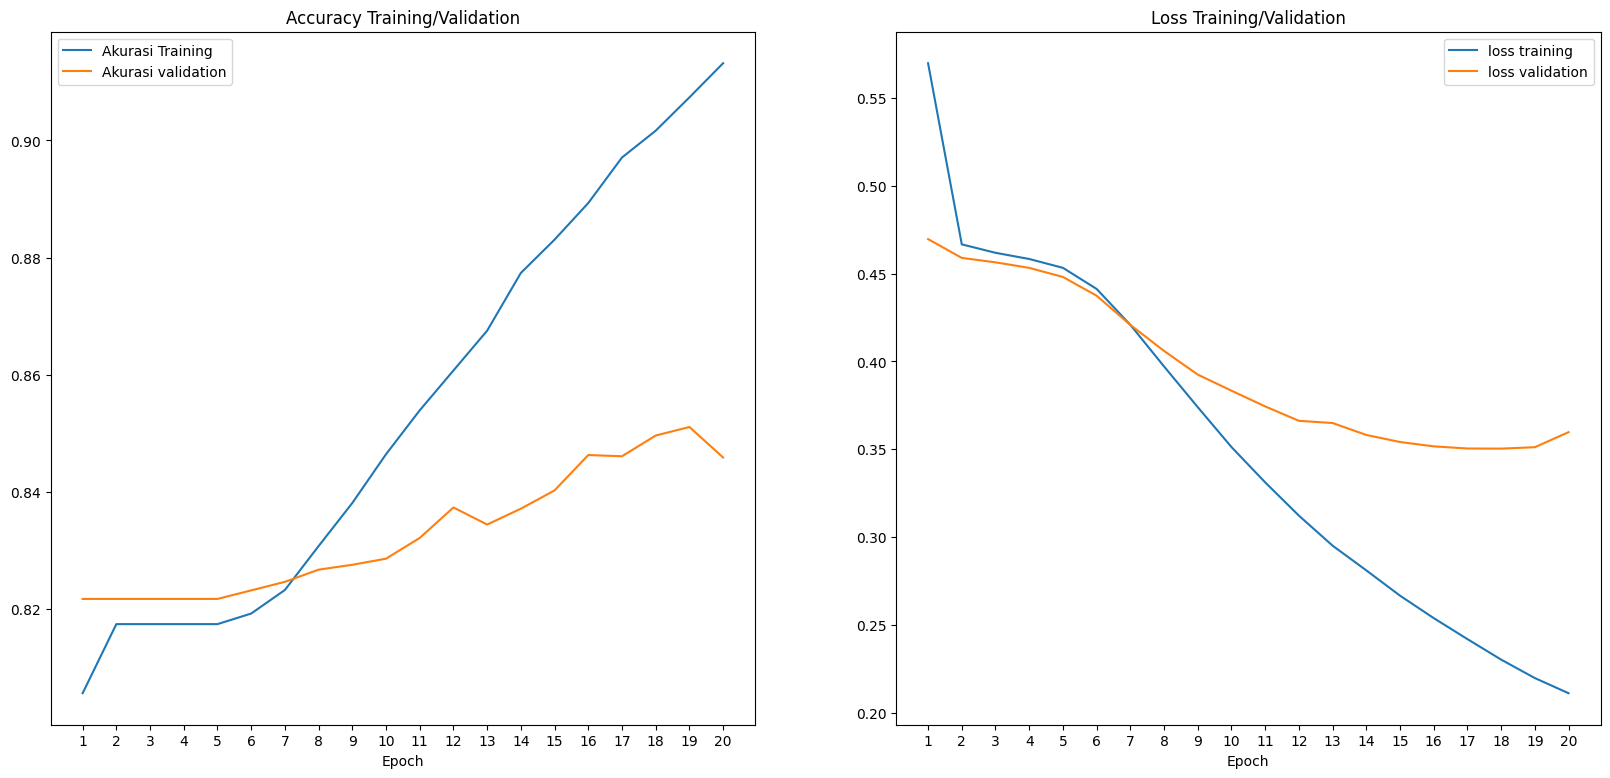

In [106]:
# VISUALISASI DATA TRAINING DAN validation
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = np.arange(1,len(acc)+1)

#proses visualisasi
plt.figure(figsize=(20,9))

# bagian visualisasi history akurasi training dan validation
plt.subplot(1,2,1)
sns.lineplot(x=epoch,y=acc,label='Akurasi Training')
sns.lineplot(x=epoch,y=val_acc,label='Akurasi validation')
plt.xlabel("Epoch")
plt.title("Accuracy Training/Validation")
plt.xticks(epoch,epoch)

# bagian visualisasi history loss training dan validation
plt.subplot(1,2,2)
sns.lineplot(x=epoch,y=loss,label='loss training')
sns.lineplot(x=epoch,y=val_loss,label='loss validation')
plt.xlabel("Epoch")
plt.title("Loss Training/Validation")
plt.xticks(epoch,epoch)
plt.show()

#### c. Prediksi Melalui Inputan

In [112]:
# pada bagian ini akan mengetes program yang sebelumnya telah dilatih dari data training

text = input("Tulis review anda: ")
#deklarasi variabel predict_sentences yang fungsinya untuk mengkonfersi huruf huruf yang dimasukan menjadi nilai angka.
predict_sentences = tokenizer.texts_to_sequences([text])

#deklarasi variabel predict_padded yang berfungsi memasukan angka agnka hasil konfersi dari perkata tadi kedalam matriks
predict_padded = pad_sequences(predict_sentences, maxlen=max_length)

#deklarasi variabel "" untuk menampilkan nilai prediksi dari variabel predict_padded
prediction = model.predict(predict_padded)[0][0]

if  prediction <= 0.5:
    print(f"Hasil Analisis Sentimen: Jelek ({prediction})")
elif prediction > 0.5:
    print(f"Hasil Analisis Sentimen: Bagus ({prediction})")



1/1 [==============================] - 0s 40ms/step
Hasil Analisis Sentimen: Jelek (0.06789716333150864)


#### d. Prediksi Melalui Sekumpulan Review Langsung

In [120]:
test_reviews = [
  ["Game nya bagus,tapi tolong pin penanda map nya di tambah lagi karena pulaunya kan makin banyak", "Bagus", "", "0"],
  ["Good game", "Bagus", "", "0"],
  ["Grinding gak enak. Resin kelamaan, tingkatin batas condesed resin atau maks resin", "Jelek", "", "0"],
  ["Mainkan game ini karena game ini sangat mantappu jiwaaaaaaaaa", "Bagus", "", "0"],
  ["gim gacha gajelas", "Jelek", "", "0"],
  ["Game sial,bisa gak hapus karakter qiqi, soalnya di banner event aku dapet qiqi mulu,dasar game sialan", "Jelek", "", "0"],
  ["Game ini tidak ramah untuk anak anak", "Jelek", "", "0"],
  ["Udah kayak nonton anime aja main game ini mantap👍👍👍", "Bagus", "", "0"],
  ["Game yang seru", "Bagus", "", "0"],
  ["Cukup mengecewakan, semoga dapat lebih baik lagi.", "Jelek", "", "0"],
]

table = PrettyTable(['Review', 'Sentimen', 'Prediksi', 'Hasil'])
table.title = "Prediksi"
table.align = "l"
for test_review in test_reviews:
    predict_sentences = tokenizer.texts_to_sequences([test_review[0]])
    predict_padded = pad_sequences(predict_sentences, maxlen=max_length)
    prediction = model.predict(predict_padded)[0][0]
    test_review[2] = "Jelek" if prediction <= 0.5 else "Bagus"
    test_review[3] = "1" if test_review[2] == test_review[1] else "0"
    table.add_row(test_review)
print(table)

1/1 [==============================] - 0s 20ms/step
+-------------------------------------------------------------------------------------------------------------------------------------+
|                                                             Indeks Kata                                                             |
+-------------------------------------------------------------------------------------------------------+----------+----------+-------+
| Review                                                                                                | Sentimen | Prediksi | Hasil |
+-------------------------------------------------------------------------------------------------------+----------+----------+-------+
| Game nya bagus,tapi tolong pin penanda map nya di tambah lagi karena pulaunya kan makin banyak        | Bagus    | Bagus    | 1     |
| Good game                                                                                             | Bagus    | Bagus    | 1   